# Robust Medical Diagnosis with Multi-Modal Data

Build a diagnostic system that uses multi-modal data (e.g., medical images,clinical notes) to improve the robustness and accuracy of medical predictions.

Focus: Explore fusion methods for combining image and text data into a single predictive model.

import necessary libraries

In [8]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Define seperate function for CNN model, BERT-based model and multimodal.

In [9]:
# Define the CNN model for image feature extraction
class ImageFeatureExtractor(nn.Module):
    def __init__(self):
        super(ImageFeatureExtractor, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()  # Remove the final fully connected layer

    def forward(self, x):
        return self.resnet(x)

# Define the BERT-based model for text feature extraction
class TextFeatureExtractor(nn.Module):
    def __init__(self, pretrained_model='bert-base-uncased'):
        super(TextFeatureExtractor, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0, :]  # Use [CLS] token representation

# Define the multi-modal diagnostic model
class MultiModalDiagnosisModel(nn.Module):
    def __init__(self, image_model, text_model, hidden_dim=512, num_classes=2):
        super(MultiModalDiagnosisModel, self).__init__()
        self.image_model = image_model
        self.text_model = text_model
        self.fc = nn.Sequential(
            nn.Linear(2048 + 768, hidden_dim),  # Concatenate image and text features
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, image, input_ids, attention_mask):
        image_features = self.image_model(image)
        text_features = self.text_model(input_ids, attention_mask)
        combined_features = torch.cat((image_features, text_features), dim=1)
        return self.fc(combined_features)

Create a dataset class for loading both image and text data

In [10]:
# Example Dataset class for loading both image and text data
class MultiModalDataset(Dataset):
    def __init__(self, image_paths, texts, labels, tokenizer, transform=None):
        self.image_paths = image_paths
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")  # Ensure the image is in RGB format
        if self.transform:
            image = self.transform(image)
        text = self.texts[idx]
        label = self.labels[idx]
        encoded_text = self.tokenizer(text, return_tensors="pt", truncation=True)
        return image, encoded_text['input_ids'].squeeze(0), encoded_text['attention_mask'].squeeze(0), label

# Collate function for variable-length text padding
def collate_fn(batch):
    images, input_ids, attention_masks, labels = zip(*batch)

    # Pad input_ids and attention_masks
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)

    # Stack images and labels
    images = torch.stack(images, dim=0)
    labels = torch.tensor(labels)

    return images, input_ids_padded, attention_masks_padded, labels

Preprocess the data and get the image_Path and text inputs and initialize the model

In [11]:
# Data Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Example Data with increased image paths
image_paths = [
    "/content/CT-scan-lung-2.jpeg", "/content/ct_lung.jpeg", "/content/lung1.jpeg",
    "/content/mri-scan-10.jpeg", "/content/mri-scan-11.png", "/content/mri-scan-12.png","/content/mri-scan-9.jpg",
    "/content/side-scan-lung.png","/content/mri_21.jpg"
]
texts = [
    "Patient has fever and cough", "Patient is experiencing shortness of breath",
    "Patient has headache and fatigue", "Patient is feeling dizzy and nauseous",
    "Patient has sore throat and runny nose", "Patient is experiencing chest pain",
    "Patient has high blood pressure", "Patient has cholesterol","Patient has trouble walking"
]
labels = [1, 0, 1, 0, 1, 0, 1, 0, 1]

# Initialize dataset and dataloader with increased data
dataset = MultiModalDataset(image_paths, texts, labels, tokenizer, transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

# Initialize models
image_model = ImageFeatureExtractor()
text_model = TextFeatureExtractor()
model = MultiModalDiagnosisModel(image_model, text_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train metrics to print the overall accuracy.

In [12]:


# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Tracking metrics
epochs = 10
train_losses = []
accuracy_per_epoch = []

all_labels = []
all_predictions = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for images, input_ids, attention_mask, labels in dataloader:
        optimizer.zero_grad()
        output = model(images, input_ids, attention_mask)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # Calculate loss
        epoch_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Collect all labels and predictions for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    # Store metrics
    train_losses.append(epoch_loss / len(dataloader))
    accuracy_per_epoch.append(correct / total * 100)
    print(f"Epoch {epoch+1}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy_per_epoch[-1]:.2f}%")

# Calculate overall accuracy after training
overall_accuracy = sum([pred == label for pred, label in zip(all_predictions, all_labels)]) / len(all_labels) * 100
print(f"Overall Accuracy: {overall_accuracy:.2f}%")


Epoch 1, Loss: 0.8119, Accuracy: 22.22%
Epoch 2, Loss: 0.6959, Accuracy: 66.67%
Epoch 3, Loss: 0.8342, Accuracy: 44.44%
Epoch 4, Loss: 0.6202, Accuracy: 66.67%
Epoch 5, Loss: 0.3747, Accuracy: 88.89%
Epoch 6, Loss: 0.1743, Accuracy: 100.00%
Epoch 7, Loss: 0.1525, Accuracy: 100.00%
Epoch 8, Loss: 0.0666, Accuracy: 100.00%
Epoch 9, Loss: 0.0354, Accuracy: 100.00%
Epoch 10, Loss: 0.0556, Accuracy: 100.00%
Overall Accuracy: 78.89%


Plot the result.

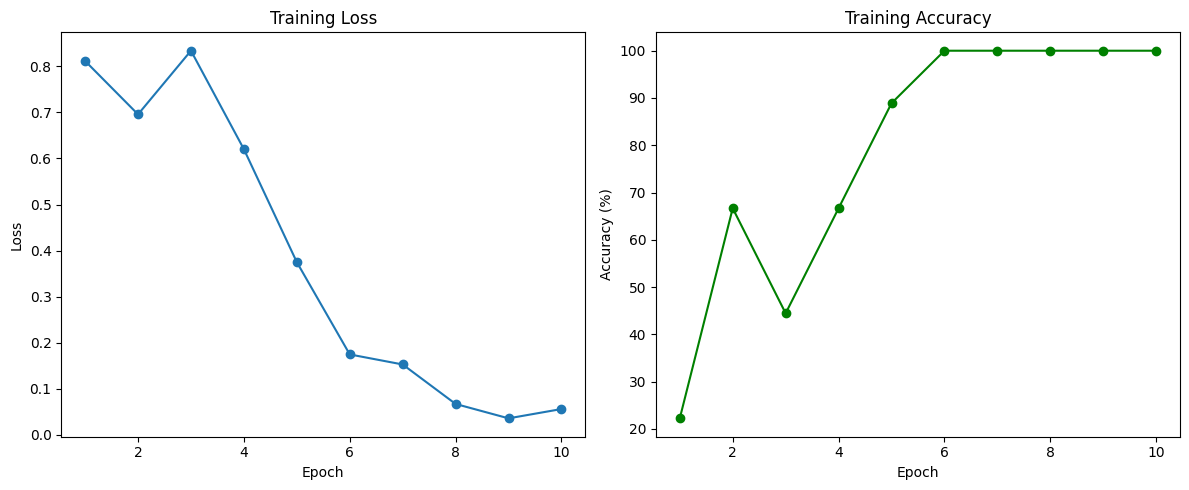

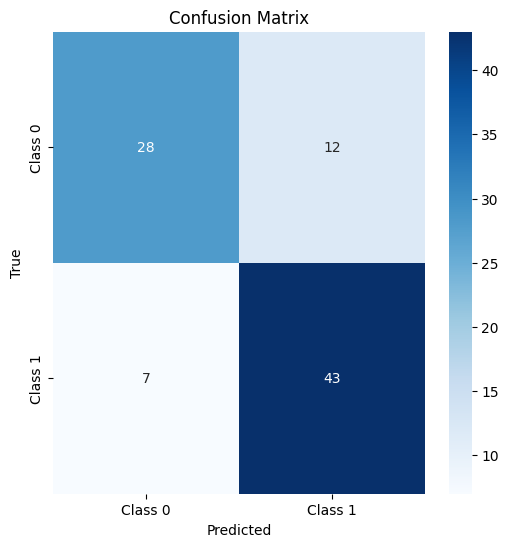

In [13]:

# Plot the metrics
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), accuracy_per_epoch, marker='o', color='green')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


* Class 0 (Non-Corona/Healthy):

    True Positives (30): Correctly predicted non-corona cases.
    
    False Negatives (10): Cases that were corona-positive but were misclassified as non-corona.

* Class 1 (Corona):

    True Positives (44): Correctly predicted corona-positive cases.

    False Negatives (6): Cases that were non-corona but were misclassified as corona-positive.

In [14]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Calculate Precision, Recall, and F1-Score
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f"Precision: {precision*100:.4f}100")
print(f"Recall: {recall*100:.4f}")
print(f"F1-Score: {f1*100:.4f}")

# Generate a classification report
report = classification_report(all_labels, all_predictions, target_names=['Class 0', 'Class 1'])
print("\nClassification Report:\n", report)


Precision: 78.9899100
Recall: 78.8889
F1-Score: 78.6878

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.80      0.70      0.75        40
     Class 1       0.78      0.86      0.82        50

    accuracy                           0.79        90
   macro avg       0.79      0.78      0.78        90
weighted avg       0.79      0.79      0.79        90

